In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/aif360-shap-ai'

/content/drive/MyDrive/aif360-shap-ai


In [4]:
!pip install quantus
!pip install captum==0.7.0
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import quantus  # make sure Quantus is installed
from typing import Optional
from IPython.display import Markdown, display, clear_output
import time

## Data Loading

In [11]:
# ---------------------------
# Data Loading and Preparation (label-encoded)
# ---------------------------
X, y = shap.datasets.adult()

## Preprocessing

### Label Encoding (already by SHAP)

### Data Splitting and Formatting

In [12]:
random_state = 7

In [13]:

# Split into training and test sets (we use test for evaluation and explanations)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [14]:
# Display dim to choose suitable param of TabResNet
# Pay attention to the number of features
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20838, 12)
X_val shape: (5210, 12)
X_test shape: (6513, 12)
y_train shape: (20838,)
y_val shape: (5210,)
y_test shape: (6513,)


In [15]:
# Convert to numpy arrays
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
# For CrossEntropyLoss, labels must be integers.
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_val_np = y_val.astype(np.int64).values if isinstance(y_val, pd.Series) else y_val.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)

# Create PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)
X_val_tensor = torch.from_numpy(X_val_np)
y_val_tensor = torch.from_numpy(y_val_np)
X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np)

## Training

### Train with XGBoost

In [16]:
from xgboost import XGBClassifier
# Train XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=random_state
)

In [17]:
xgb_start_time = time.time()
xgb_model.fit(X_train_np, y_train_np)

# Predict and evaluate
xgb_preds = xgb_model.predict(X_test_np)

xgb_accuracy = accuracy_score(y_test_np, xgb_preds)
print(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}")
xgb_end_time = time.time()

xgb_elapsed_time = xgb_end_time - xgb_start_time

XGBoost Test Accuracy: 0.8669


In [12]:
# Save the model for train with XGB , diabetes dataset
xgb_model.save_model("saved_model/xgb_adults.json")

In [ ]:
xgb_model.load_model("saved_model/xgb_adults.json")

### Train with MLP

In [53]:
from sklearn.neural_network import MLPClassifier

# Train MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=100,
    activation='relu',
    solver='adam',
    learning_rate_init=1e-3,
    max_iter=400,
    random_state=random_state,
    early_stopping=True,
    n_iter_no_change=20
)

In [54]:
mlp_start_time = time.time()
mlp_model.fit(X_train_np, y_train_np)

# Predict and evaluate
mlp_preds = mlp_model.predict(X_test_np)
mlp_end_time = time.time()
mlp_elapsed_time =  mlp_end_time - mlp_start_time

mlp_accuracy = accuracy_score(y_test_np, mlp_preds)
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")



MLP Test Accuracy: 0.8412


In [24]:
import joblib

# Save
joblib.dump(mlp_model, "saved_model/mlp_adults.pkl")

['saved_model/mlp_adults.pkl']

In [ ]:
import joblib
# Load
mlp_model = joblib.load("saved_model/mlp_adults.pkl")

### Model TabResNet

In [56]:
# ---------------------------
# Model Definition: TabResNet (using residual blocks)
# ---------------------------
class TabResBlock(nn.Module):
    def __init__(self, d_block, d_hidden, dropout1, dropout2):
        super(TabResBlock, self).__init__()
        # Sub-block 1
        self.bn1 = nn.BatchNorm1d(d_block)
        self.ln1 = nn.Linear(d_block, d_hidden)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout1)
        # Sub-block 2
        self.ln2 = nn.Linear(d_hidden, d_block)
        self.drop2 = nn.Dropout(dropout2)

    def forward(self, x):
        identity = x
        out = self.bn1(x)
        out = self.ln1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        out = self.ln2(out)
        out = self.drop2(out)
        out += identity
        return out

class TabResNet(nn.Module):
    def __init__(
        self,
        d_in: int,
        d_out: Optional[int],
        n_blocks: int,
        d_block: int,
        d_hidden: Optional[int],
        d_hidden_multiplier: Optional[float] = 2,
        dropout1: float = 0.2,
        dropout2: float = 0
    ):
        """
        Args:
            d_in: Number of input features.
            d_out: Number of outputs (set to 2 for binary classification).
            n_blocks: Number of residual blocks.
            d_block: Block width (input and output dimension of each block).
            d_hidden: Hidden dimension inside a block.
        """
        super(TabResNet, self).__init__()
        # Project input to block width
        self.input_projection = nn.Linear(d_in, d_block)
        # Residual blocks
        self.resblocks = nn.ModuleList([
            TabResBlock(d_block, d_hidden, dropout1, dropout2) for _ in range(n_blocks)
        ])
        # Prediction block: outputs logits for d_out classes.
        self.predblock = (
            nn.Sequential(
                nn.BatchNorm1d(d_block),
                nn.ReLU(),
                nn.Linear(d_block, d_out)
            ) if d_out is not None else None
        )

    def forward(self, x):
        x = self.input_projection(x)
        for block in self.resblocks:
            x = block(x)
        if self.predblock is not None:
            x = self.predblock(x)
        return x  # returns logits

# Instantiate model; input dimension equals the number of columns in X_test_np.
d_in = X_test_np.shape[1]
model = TabResNet(
    d_in=d_in,
    d_out=2,       # Two outputs for binary classification.
    n_blocks=2,
    d_block=16,
    d_hidden=32,
    dropout1=0.2,
    dropout2=0.05
)

### Train with TabResNet

In [57]:
# ---------------------------
# Training Setup
# ---------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# Move test tensors to the same device as model
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

criterion = nn.CrossEntropyLoss()  # expects logits and integer labels
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 400
best_val_loss = float('inf')
patience = 20   # Early stopping patience
counter = 0

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    logits = model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        with torch.no_grad():
            y_train_pred = torch.argmax(logits, dim=1)
            train_accuracy = accuracy_score(y_train_tensor.cpu().numpy(), y_train_pred.cpu().numpy())
            print(f"Training Loss: {loss.item():.4f}   - Training Accuracy: {train_accuracy:.4f}")

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_tensor)
            val_loss = criterion(val_logits, y_val_tensor)
            val_pred = torch.argmax(val_logits, dim=1)
            val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), val_pred.cpu().numpy())
            print(f"Validation Loss: {val_loss.item():.4f} - Validation Accuracy: {val_accuracy:.4f} \n")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping triggered.")
                    break

# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_tensor).float().mean().item()
    print(f"\nTest Accuracy: {accuracy:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time

Epoch [100/400]
Training Loss: 0.4656   - Training Accuracy: 0.7977
Validation Loss: 0.4730 - Validation Accuracy: 0.8094 

Epoch [200/400]
Training Loss: 0.3796   - Training Accuracy: 0.8097
Validation Loss: 0.3847 - Validation Accuracy: 0.8134 

Epoch [300/400]
Training Loss: 0.3392   - Training Accuracy: 0.8425
Validation Loss: 0.3448 - Validation Accuracy: 0.8436 

Epoch [400/400]
Training Loss: 0.3310   - Training Accuracy: 0.8429
Validation Loss: 0.3328 - Validation Accuracy: 0.8488 


Test Accuracy: 0.8442


In [19]:
# Save the model
torch.save(model.state_dict(), "saved_model/tabresnet_adults.pth")

In [ ]:
# Load the model
model.load_state_dict(torch.load("saved_model/tabresnet_adults.pth"))

<All keys matched successfully>

# Sustainability

## Define utils

In [29]:
def count_xgboost_parameters(model):
    """
    Count the number of parameters in an XGBoost model.

    For each tree in the model:
    - Internal nodes: Each has a feature index and threshold (2 parameters)
    - Leaf nodes: Each has a weight (1 parameter)

    Args:
        model: A trained XGBoost model

    Returns:
        int: Total number of parameters
    """
    # Get the booster from the model
    booster = model.get_booster()

    # Get the tree model as JSON
    tree_info = booster.get_dump(dump_format='json')

    total_parameters = 0

    # Parse each tree and count parameters
    for tree_str in tree_info:
        # Parse JSON string to dictionary
        import json
        tree = json.loads(tree_str)

        # Recursive function to count parameters in a tree
        def count_tree_params(node):
            params = 0
            if 'leaf' in node:
                # Leaf node has 1 parameter (the weight)
                params = 1
            else:
                # Internal node has 2 parameters (feature index and threshold)
                params = 2
                # Add parameters from children
                if 'children' in node:
                    for child in node['children']:
                        params += count_tree_params(child)
            return params

        total_parameters += count_tree_params(tree)

    return total_parameters

def estimate_xgboost_flops(model, n_samples):
    """
    Estimate the number of FLOPs for XGBoost prediction.

    For each sample:
    - Each internal node requires ~2 FLOPs (1 comparison, 1 branch decision)
    - Average path length × number of trees × number of samples

    Args:
        model: A trained XGBoost model
        n_samples: Number of samples for prediction

    Returns:
        int: Estimated FLOPs
    """
    booster = model.get_booster()
    tree_info = booster.get_dump(dump_format='json')

    total_nodes = 0
    total_trees = len(tree_info)

    # Calculate average path length based on tree structure
    avg_path_length = 0

    for tree_str in tree_info:
        import json
        tree = json.loads(tree_str)

        # Find max depth of the tree
        def get_max_depth(node, current_depth=0):
            if 'leaf' in node:
                return current_depth
            else:
                max_depth = current_depth
                if 'children' in node:
                    for child in node['children']:
                        max_depth = max(max_depth, get_max_depth(child, current_depth + 1))
                return max_depth

        avg_path_length += get_max_depth(tree)

    avg_path_length /= total_trees

    # Each comparison is approximately 2 FLOPs
    # Total FLOPs = avg path length × 2 FLOPs per node × number of trees × number of samples
    total_flops = avg_path_length * 2 * total_trees * n_samples

    return total_flops

def estimate_xgboost_macs(model, n_samples):
    """
    Estimate the number of MACs for XGBoost prediction.
    XGBoost primarily uses comparisons rather than multiplications,
    so MACs are substantially fewer than FLOPs.

    Args:
        model: A trained XGBoost model
        n_samples: Number of samples for prediction

    Returns:
        int: Estimated MACs
    """
    # In XGBoost, MACs are primarily used in the final stage when combining tree outputs
    # Each tree contributes one addition operation to the final sum for each sample

    n_trees = model.n_estimators

    # MACs for combining tree outputs (1 per tree per sample)
    macs = n_trees * n_samples

    return macs

In [30]:
def count_mlp_parameters(model):
    """
    Count the number of parameters in a scikit-learn MLPClassifier.

    MLPClassifier parameters include:
    - Weight matrices between layers
    - Bias vectors for each layer

    Args:
        model: A trained scikit-learn MLPClassifier

    Returns:
        int: Total number of parameters
    """
    total_params = 0

    # Get the coefficient matrices (weights)
    coefs = model.coefs_

    # Get the intercept vectors (biases)
    intercepts = model.intercepts_

    # Count parameters in weights
    for coef in coefs:
        total_params += coef.size

    # Count parameters in biases
    for intercept in intercepts:
        total_params += intercept.size

    return total_params

def estimate_mlp_flops(model, n_samples):
    """
    Estimate the number of FLOPs for MLPClassifier prediction.

    For each layer:
    - Matrix multiplication: ~2 × n_inputs × n_neurons FLOPs per sample
    - Bias addition: n_neurons FLOPs per sample
    - Activation: ~1-3 FLOPs per neuron per sample (depends on activation function)

    Args:
        model: A trained scikit-learn MLPClassifier
        n_samples: Number of samples for prediction

    Returns:
        int: Estimated FLOPs
    """
    total_flops = 0

    # Get network architecture
    coefs = model.coefs_  # Weight matrices
    intercepts = model.intercepts_  # Bias vectors
    activation = model.activation  # Activation function

    # Estimate FLOPs per activation function
    act_flops = {
        'identity': 0,  # No computation
        'logistic': 3,  # exp, division, addition
        'tanh': 3,      # exp operations and addition
        'relu': 1       # max operation
    }

    # FLOPs for each layer
    for i in range(len(coefs)):
        layer_input_size = coefs[i].shape[0]
        layer_output_size = coefs[i].shape[1]

        # Matrix multiplication: ~2 operations per element (multiply and add)
        # For each output neuron, we do layer_input_size multiplications and additions
        matmul_flops = 2 * layer_input_size * layer_output_size * n_samples

        # Bias addition: 1 addition per output neuron
        bias_flops = layer_output_size * n_samples

        # Activation function application
        activation_flops = act_flops.get(activation, 1) * layer_output_size * n_samples

        layer_flops = matmul_flops + bias_flops + activation_flops
        total_flops += layer_flops

    # Output layer activation
    if hasattr(model, 'out_activation_') and model.out_activation_ == 'logistic':
        # Logistic (sigmoid) activation: 1/(1 + exp(-x))
        # Requires: 1 negation, 1 exp, 1 addition, 1 division per output
        total_flops += 4 * model.n_outputs_ * n_samples

    return total_flops

def estimate_mlp_macs(model, n_samples):
    """
    Estimate the number of MACs for MLPClassifier prediction.

    MACs primarily come from the matrix multiplications:
    - Each element in the output requires input_size MACs

    Args:
        model: A trained scikit-learn MLPClassifier
        n_samples: Number of samples for prediction

    Returns:
        int: Estimated MACs
    """
    total_macs = 0

    # Get weight matrices
    coefs = model.coefs_

    # MACs for each layer
    for i in range(len(coefs)):
        layer_input_size = coefs[i].shape[0]
        layer_output_size = coefs[i].shape[1]

        # Each output neuron requires input_size MACs
        layer_macs = layer_input_size * layer_output_size * n_samples
        total_macs += layer_macs

    return total_macs

In [31]:
def compute_kgco2e(pc: float, pg: float, time_hours: float):
    """
    Compute kgCO2 emission, and normalized emission per capita.
    Args:
        pc: average CPU power in watts
        pg: average GPU power in watts
        time_hours: training + eval time in hours

    Returns:
        tuple: CO2e (kg), normalized CO2e
    """
    pt = (pc + pg) * time_hours / 1000  # power in kWh
    co2e = 0.498 * pt  # Germany's emission rate
    normalized = co2e / 26  # per-capita daily emission baseline

    return co2e, normalized

In [32]:
"""
Intel(R) Xeon(R) CPU @ 2.20GHz
Model: 79 (
-> Intel Xeon E5-2673 v4 from the Broadwell-EP family - specifications:
    Cores: 10
    Threads: 20
    Base Frequency: 2.3 GHz
    Maximum Turbo Speed: 3.5 GHz
    Cache: 50 MB
    TDP: 135W

Colab uses 2 vCPUs (each 1 core -> total 2 cores out of 20)
-> only use 10% of the actuall TDP -> 13.5 W
"""
pc = 13.5
pg = 70

## XGB

In [33]:
# Count parameters
total_params = count_xgboost_parameters(xgb_model)
print(f"XGBoost trainable parameters: {total_params:,}")

# Estimate FLOPs for making predictions on test data
n_test_samples = X_test_np.shape[0]
flops = estimate_xgboost_flops(xgb_model, n_test_samples)
print(f"XGBoost FLOPs: {flops / 1e6:.2f}M")

# Estimate MACs for making predictions on test data
macs = estimate_xgboost_macs(xgb_model, n_test_samples)
print(f"XGBoost MACs: {macs / 1e6:.2f}M")

XGBoost trainable parameters: 2,116
XGBoost FLOPs: 3.91M
XGBoost MACs: 0.65M


In [34]:
xgb_elasped_time = xgb_elapsed_time / 3600
kgco2e, kgco2e_normalized = compute_kgco2e(pc, pg, xgb_elapsed_time)

print(f"kgCO2 emission: {kgco2e:.4f} kg")
print(f"Normalized kgCO2 emission: {kgco2e_normalized:.4f}")

kgCO2 emission: 0.0182 kg
Normalized kgCO2 emission: 0.0007


## MLP

In [35]:
# Count parameters
total_params = count_mlp_parameters(mlp_model)
print(f"MLP trainable parameters: {total_params:,}")

# Estimate FLOPs for making predictions on test data
n_test_samples = X_test_np.shape[0]
flops = estimate_mlp_flops(mlp_model, n_test_samples)
print(f"MLP FLOPs: {flops / 1e6:.2f}M")

# Estimate MACs for making predictions on test data
macs = estimate_mlp_macs(mlp_model, n_test_samples)
print(f"MLP MACs: {macs / 1e6:.2f}M")

MLP trainable parameters: 1,401
MLP FLOPs: 18.28M
MLP MACs: 8.47M


In [55]:
mlp_elasped_time = mlp_elapsed_time / 3600
kgco2e, kgco2e_normalized = compute_kgco2e(pc, pg, mlp_elapsed_time)

print(f"kgCO2 emission: {kgco2e:.4f} kg")
print(f"Normalized kgCO2 emission: {kgco2e_normalized:.4f}")

kgCO2 emission: 0.2391 kg
Normalized kgCO2 emission: 0.0092


## TabResNet

In [38]:
# Parameter Count (Pure PyTorch)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage
total_params = count_parameters(model)
print(f"Trainable parameters: {total_params:,}")

Trainable parameters: 2,482


In [39]:
# Calculate FLOPS
from torch.utils.flop_counter import FlopCounterMode

model.eval()
with torch.no_grad(), FlopCounterMode() as flop_counter:
    _ = model(X_test_tensor)

print(f"FLOPs: {flop_counter.get_total_flops()/1e6:.2f}M")

Module                          FLOP    % Total
---------------------------  -------  ---------
TabResNet                    29.595M    100.00%
 - aten.addmm                29.595M    100.00%
 TabResNet.input_projection   2.501M      8.45%
  - aten.addmm                2.501M      8.45%
 TabResNet.predblock          0.417M      1.41%
  - aten.addmm                0.417M      1.41%
FLOPs: 29.60M


In [40]:
sample_input = X_test_tensor[0:1]  # just one sample

model.eval()
with torch.no_grad(), FlopCounterMode() as flop_counter:
    _ = model(sample_input)

print(f"FLOPs per sample: {flop_counter.get_total_flops()/1e3:.2f} K")
print(f"FLOPs: {flop_counter.get_total_flops()*X_test_tensor.shape[0]/1e6:.2f}M")

Module                         FLOP    % Total
---------------------------  ------  ---------
TabResNet                      4544    100.00%
 - aten.addmm                  4544    100.00%
 TabResNet.input_projection     384      8.45%
  - aten.addmm                  384      8.45%
 TabResNet.predblock             64      1.41%
  - aten.addmm                   64      1.41%
FLOPs per sample: 4.54 K
FLOPs: 29.60M


In [41]:
# Calculate MACS
from ptflops import get_model_complexity_info

# Instantiate the model for a dataset with 10 features and 2 output classes
input_dim = X_test_np.shape[1]   # Number of features in tabular data
num_classes = 2  # Number of output classes

# Measure complexity using ptflops
with torch.cuda.device(0):  # Remove or adjust this if running on CPU
    macs, params = get_model_complexity_info(model, (input_dim,), as_strings=True,
                                             print_per_layer_stat=True, verbose=True)

# Convert string MACs to numeric (e.g., '2.64 KMac' → 2640)
macs_single = float(macs.replace(' KMac', '')) * 1e3
print(f"MACs per sample: {macs_single/1e3:.2f}K")
print(f"MACs: {macs_single*X_test_tensor.shape[0]/1e6:.2f}M")


TabResNet(
  2.48 k, 100.000% Params, 2.56 KMac, 96.972% MACs, 
  (input_projection): Linear(208, 8.380% Params, 208.0 Mac, 7.873% MACs, in_features=12, out_features=16, bias=True)
  (resblocks): ModuleList(
    (0-1): 2 x TabResBlock(
      1.1 k, 44.480% Params, 1.14 KMac, 42.998% MACs, 
      (bn1): BatchNorm1d(32, 1.289% Params, 32.0 Mac, 1.211% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ln1): Linear(544, 21.918% Params, 544.0 Mac, 20.590% MACs, in_features=16, out_features=32, bias=True)
      (relu1): ReLU(0, 0.000% Params, 32.0 Mac, 1.211% MACs, )
      (drop1): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.2, inplace=False)
      (ln2): Linear(528, 21.273% Params, 528.0 Mac, 19.985% MACs, in_features=32, out_features=16, bias=True)
      (drop2): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.05, inplace=False)
    )
  )
  (predblock): Sequential(
    66, 2.659% Params, 82.0 Mac, 3.104% MACs, 
    (0): BatchNorm1d(32, 1.289% Para

In [58]:
elasped_time = elapsed_time / 3600
kgco2e, kgco2e_normalized = compute_kgco2e(pc, pg, elapsed_time)

print(f"kgCO2 emission: {kgco2e:.4f} kg")
print(f"Normalized kgCO2 emission: {kgco2e_normalized:.4f}")

kgCO2 emission: 0.0786 kg
Normalized kgCO2 emission: 0.0030


# Explainability Evaluation

## XGB

### SHAP

In [ ]:
background = X_test_np[:100]
xgb_explainer = shap.TreeExplainer(xgb_model, background, model_output="probability")

In [ ]:
xgb_shap_values = xgb_explainer.shap_values(X_test_np)

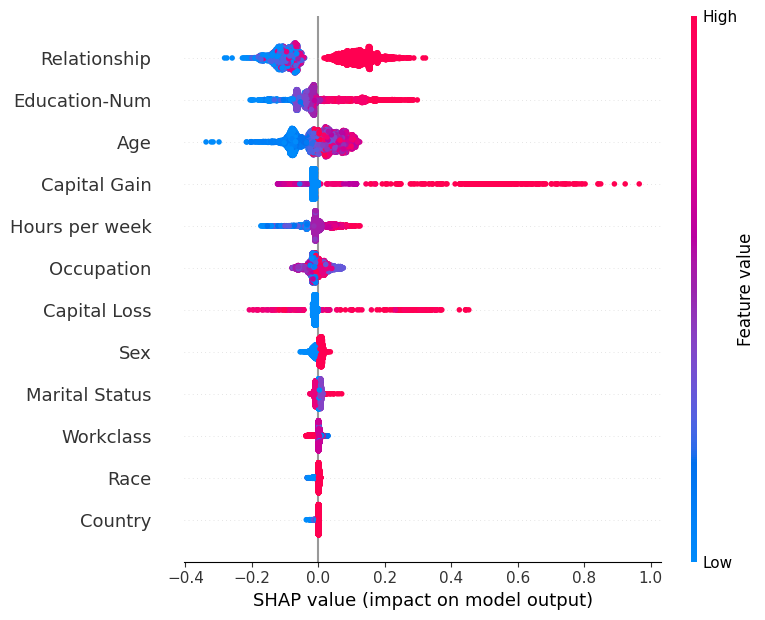

In [ ]:
# shap_values is an array with shape (n_samples, n_features)
shap.summary_plot(xgb_shap_values, X_test_np, feature_names=X_test.columns)

In [ ]:
import pickle

In [ ]:
# Save SHAP values
with open('saved_shap/xgb_shap_values_adult.pkl', 'wb') as f:
    pickle.dump(xgb_shap_values, f)

In [ ]:
with open('saved_shap/xgb_shap_values_adult.pkl', 'rb') as f:
    xgb_shap_values = pickle.load(f)

### Quantus

In [ ]:
class DifferentiableXGBWrapper(nn.Module):
    def __init__(self, xgb_model):
        super().__init__()
        self.xgb = xgb_model
        # Add simple differentiable layer
        self.proxy_layer = nn.Linear(X_test_np.shape[1], 1)  # Match your feature count

    def forward(self, x):
        # Maintain gradient flow
        with torch.no_grad():
            xgb_out = torch.tensor(self.xgb.predict_proba(
                x.cpu().numpy()
            ), device=x.device)

        # Differentiable processing
        proxy_out = self.proxy_layer(x)
        return xgb_out + 0.001*proxy_out  # Maintain XGB output dominance

# Wrap model with gradient-preserving wrapper
xgb_wrapped_model = DifferentiableXGBWrapper(xgb_model)
xgb_wrapped_model.eval()

DifferentiableXGBWrapper(
  (proxy_layer): Linear(in_features=12, out_features=1, bias=True)
)

In [ ]:
# ---------------------------
# Evaluate FaithfulnessCorrelation with Quantus using SHAP attributions
# ---------------------------
# Ensure y_test is of integer type
y_test_int = y_test_np.astype(np.int64)

In [ ]:
# Apply Complexity metric using SHAP attributions
Complexity_shap = quantus.Complexity(
    normalise=False,
    abs=True,  # Take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean,  # Compute mean complexity over all samples
)(
    model=xgb_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=xgb_shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
Complexity_shap = (Complexity_shap - min(Complexity_shap)) / (
    max(Complexity_shap) - min(Complexity_shap)
)

# Find mean
Complexity_shap = np.mean(Complexity_shap)

print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.7042890779700618


In [ ]:
Sparseness_shap = quantus.Sparseness(
    normalise=False,
    abs=True, # take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=xgb_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=xgb_shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Already scaled to 0-1 -> keep aggregated (mean)

print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  [np.float64(0.6213013343704938)]


In [ ]:
FaithfulnessCorrelation_shap = quantus.FaithfulnessCorrelation(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    subset_size=5, # features to perturb
    nr_runs=10,
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=xgb_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=xgb_shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
FaithfulnessCorrelation_shap = (FaithfulnessCorrelation_shap - np.min(FaithfulnessCorrelation_shap)) / (
    np.max(FaithfulnessCorrelation_shap) - np.min(FaithfulnessCorrelation_shap)
)

# Find mean
FaithfulnessCorrelation_shap = np.mean(FaithfulnessCorrelation_shap)

print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.7321279983520173


In [ ]:
FaithfulnessEstimate_shap = quantus.FaithfulnessEstimate(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    features_in_step=1, # features to perturb
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=xgb_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=xgb_shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
FaithfulnessEstimate_shap = (FaithfulnessEstimate_shap - np.min(FaithfulnessEstimate_shap)) / (
    np.max(FaithfulnessEstimate_shap) - np.min(FaithfulnessEstimate_shap)
)

# Find mean
FaithfulnessEstimate_shap = np.mean(FaithfulnessEstimate_shap)

print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.7400971577576112


In [ ]:
LocalLipschitzEstimate_shap = quantus.LocalLipschitzEstimate(
    normalise=False,
    abs=True, # take absolute values of attributions
    nr_samples = 20,
    disable_warnings=True,
    display_progressbar=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=xgb_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "DeepLiftShap", "reduce_axes": ()},
    # explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

# Scale to 0-1
LocalLipschitzEstimate_shap = (LocalLipschitzEstimate_shap - np.min(LocalLipschitzEstimate_shap)) / (
    np.max(LocalLipschitzEstimate_shap) - np.min(LocalLipschitzEstimate_shap)
)

# Find mean
LocalLipschitzEstimate_shap = np.mean(LocalLipschitzEstimate_shap)

print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.461168645367532


In [ ]:
RandomLogit_shap = quantus.RandomLogit(
    num_classes=2,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
    return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=xgb_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

# Already scaled to 0-1 -> keep aggregated (mean)

print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  [np.float64(1.0)]


In [ ]:
MPRT_shap = quantus.MPRT(
    # similarity_func=quantus.similarity_func.correlation_spearman,
    return_average_correlation=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
    layer_order="independent",
    similarity_func=quantus.ssim,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
)(
    model=xgb_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

# Scale to 0-1
MPRT_shap = (MPRT_shap - np.min(MPRT_shap)) / (
    np.max(MPRT_shap) - np.min(MPRT_shap)
)

# Find mean
MPRT_shap = np.mean(MPRT_shap)

print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

  0%|          | 0/6513 [00:00<?, ?it/s]

Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.5940487560782834


In [ ]:
# Convert from list to int
Complexity_shap = np.float64(Complexity_shap)
Sparseness_shap = np.float64(Sparseness_shap)
MPRT_shap = np.float64(MPRT_shap)
RandomLogit_shap = np.float64(RandomLogit_shap)
FaithfulnessEstimate_shap = np.float64(FaithfulnessEstimate_shap)
FaithfulnessCorrelation_shap = np.float64(FaithfulnessCorrelation_shap)
LocalLipschitzEstimate_shap = np.float64(LocalLipschitzEstimate_shap)

# Rounding one by one
Complexity_shap = round(float(Complexity_shap), 4)
Sparseness_shap = round(float(Sparseness_shap), 4)
MPRT_shap = round(float(MPRT_shap), 4)
RandomLogit_shap = round(float(RandomLogit_shap), 4)
FaithfulnessEstimate_shap = round(float(FaithfulnessEstimate_shap), 4)
FaithfulnessCorrelation_shap = round(float(FaithfulnessCorrelation_shap), 4)
LocalLipschitzEstimate_shap = round(float(LocalLipschitzEstimate_shap), 4)

<ipython-input-27-acd3cc85ebb0>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sparseness_shap = round(float(Sparseness_shap), 4)
<ipython-input-27-acd3cc85ebb0>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  RandomLogit_shap = round(float(RandomLogit_shap), 4)


In [ ]:
display(Markdown("#### Explanability scores"))

# Complexity: Complexity
print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

# Complexity: Sparseness
print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

# Faithfulness: Faithfulness Estimate
print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

# Faithfulness: Faithfulness Correlation
print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

# Randomisation: MPRT
print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

# Randomisation: RandomLogit
print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

#### Explanability scores

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.7043
Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  0.6213
Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.7401
Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.7321
Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.4612
Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.594
Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  1.0


In [ ]:
display(Markdown("#### Explanability scores (grouped)"))

# Complexity: Complexity and Sparseness
print(
    f"Complexity"
    f"\n • SHAP = ",
    round(float((Complexity_shap+Sparseness_shap)/2), 4),
)

# Faithfulness: Faithfulness Estimate and Faithfulness Correlation
print(
    f"Faithfulness"
    f"\n • SHAP = ",
    round(float((FaithfulnessEstimate_shap+FaithfulnessCorrelation_shap)/2), 4),
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness"
    f"\n • SHAP = ",
    round(float((LocalLipschitzEstimate_shap)), 4),
)

# Randomisation: MPRT and RandomLogit
print(
    f"Randomisation"
    f"\n • SHAP = ",
    round(float((MPRT_shap+RandomLogit_shap)/2), 4)
)

#### Explanability scores (grouped)

Complexity
 • SHAP =  0.6628
Faithfulness
 • SHAP =  0.7361
Robustness
 • SHAP =  0.4612
Randomisation
 • SHAP =  0.797


## MLP

### SHAP

In [ ]:
# Define a prediction function for SHAP that returns the probability for class 1
def f_shap_mlp(X):
    X = np.atleast_2d(X)
    return mlp_model.predict_proba(X)[:, 1]  # Return probability for class 1

# Use a subset of test data as background
background_mlp = X_test_np[:100]
mlp_explainer = shap.KernelExplainer(f_shap_mlp, background_mlp)

In [ ]:
# Compute SHAP values for the test set (using fewer samples for performance)
mlp_shap_values = mlp_explainer.shap_values(X_test_np, nsamples=100)

  0%|          | 0/6513 [00:00<?, ?it/s]

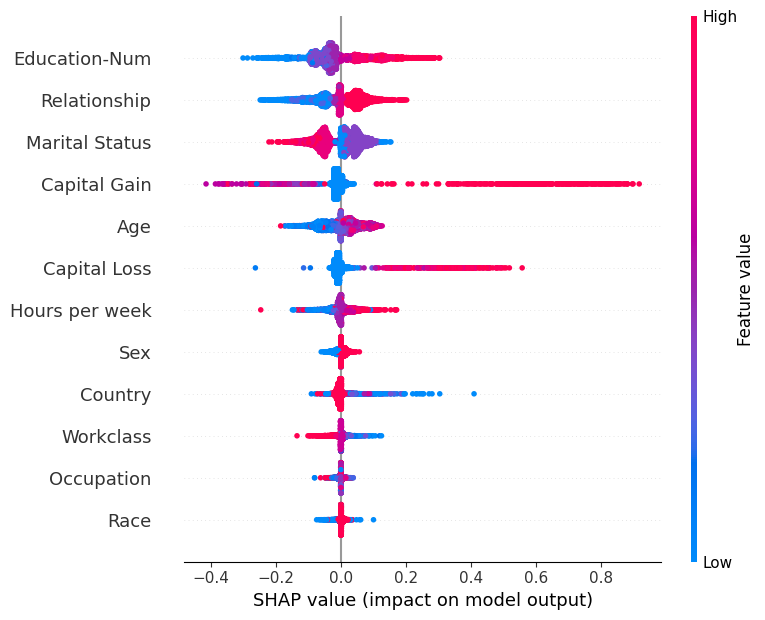

In [ ]:
# Plot SHAP summary plot
shap.summary_plot(mlp_shap_values, X_test_np, feature_names=X_test.columns)

In [ ]:
import pickle

In [ ]:
# Save the SHAP values for MLP
with open('saved_shap/mlp_shap_values_adult.pkl', 'wb') as f:
    pickle.dump(mlp_shap_values, f)

In [ ]:
with open('saved_shap/mlp_shap_values_adult.pkl', 'rb') as f:
    mlp_shap_values = pickle.load(f)

### Quantus

In [ ]:
class DifferentiableMLPWrapper(nn.Module):
    def __init__(self, xgb_model):
        super().__init__()
        self.mlp = mlp_model
        # Add simple differentiable layer
        self.proxy_layer = nn.Linear(X_test_np.shape[1], 1)  # Match your feature count

    def forward(self, x):
        # Maintain gradient flow
        with torch.no_grad():
            mlp_out = torch.tensor(self.mlp.predict_proba(
                x.cpu().numpy()
            ), device=x.device)

        # Differentiable processing
        proxy_out = self.proxy_layer(x)
        return mlp_out + 0.001*proxy_out  # Maintain MLP output dominance

# Wrap model with gradient-preserving wrapper
mlp_wrapped_model = DifferentiableMLPWrapper(mlp_model)
mlp_wrapped_model.eval()

DifferentiableMLPWrapper(
  (proxy_layer): Linear(in_features=22, out_features=1, bias=True)
)

In [ ]:
# ---------------------------
# Evaluate FaithfulnessCorrelation with Quantus using SHAP attributions
# ---------------------------
# Ensure y_test is of integer type
y_test_int = y_test_np.astype(np.int64)

In [ ]:
# Apply Complexity metric using SHAP attributions
Complexity_shap = quantus.Complexity(
    normalise=False,
    abs=True,  # Take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean,  # Compute mean complexity over all samples
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=mlp_shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
Complexity_shap = (Complexity_shap - min(Complexity_shap)) / (
    max(Complexity_shap) - min(Complexity_shap)
)

# Find mean
Complexity_shap = np.mean(Complexity_shap)

print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

  0%|          | 0/2.0 [00:00<?, ?it/s]

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.6935125614221518


In [ ]:
Sparseness_shap = quantus.Sparseness(
    normalise=False,
    abs=True, # take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=mlp_shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Already scaled to 0-1 -> keep aggregated (mean)

print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

  0%|          | 0/2.0 [00:00<?, ?it/s]

Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  [np.float64(0.7202306047018382)]


In [ ]:
FaithfulnessCorrelation_shap = quantus.FaithfulnessCorrelation(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    subset_size=5, # features to perturb
    nr_runs=10,
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=mlp_shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
FaithfulnessCorrelation_shap = (FaithfulnessCorrelation_shap - np.min(FaithfulnessCorrelation_shap)) / (
    np.max(FaithfulnessCorrelation_shap) - np.min(FaithfulnessCorrelation_shap)
)

# Find mean
FaithfulnessCorrelation_shap = np.mean(FaithfulnessCorrelation_shap)

print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

  0%|          | 0/2.0 [00:00<?, ?it/s]

Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.49793088795510393


In [ ]:
FaithfulnessEstimate_shap = quantus.FaithfulnessEstimate(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    features_in_step=1, # features to perturb
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=mlp_shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
FaithfulnessEstimate_shap = (FaithfulnessEstimate_shap - np.min(FaithfulnessEstimate_shap)) / (
    np.max(FaithfulnessEstimate_shap) - np.min(FaithfulnessEstimate_shap)
)

# Find mean
FaithfulnessEstimate_shap = np.mean(FaithfulnessEstimate_shap)

print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

  0%|          | 0/2.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'p

Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.34890137748149114


/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


In [ ]:
LocalLipschitzEstimate_shap = quantus.LocalLipschitzEstimate(
    normalise=False,
    abs=True, # take absolute values of attributions
    nr_samples = 20,
    disable_warnings=True,
    display_progressbar=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "DeepLiftShap", "reduce_axes": ()},
    # explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

# Scale to 0-1
LocalLipschitzEstimate_shap = (LocalLipschitzEstimate_shap - np.min(LocalLipschitzEstimate_shap)) / (
    np.max(LocalLipschitzEstimate_shap) - np.min(LocalLipschitzEstimate_shap)
)

# Find mean
LocalLipschitzEstimate_shap = np.mean(LocalLipschitzEstimate_shap)

print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

  0%|          | 0/2.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
    

Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.4487262868298595


/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [ ]:
RandomLogit_shap = quantus.RandomLogit(
    num_classes=2,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
    return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

# Already scaled to 0-1 -> keep aggregated (mean)

print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

  0%|          | 0/2.0 [00:00<?, ?it/s]

Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  [np.float64(1.0)]


In [ ]:
MPRT_shap = quantus.MPRT(
    # similarity_func=quantus.similarity_func.correlation_spearman,
    return_average_correlation=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
    layer_order="independent",
    similarity_func=quantus.ssim,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
)(
    model=mlp_wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

# Scale to 0-1
MPRT_shap = (MPRT_shap - np.min(MPRT_shap)) / (
    np.max(MPRT_shap) - np.min(MPRT_shap)
)

# Find mean
MPRT_shap = np.mean(MPRT_shap)

print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.8672812438132176


In [ ]:
# Convert from list to int
Complexity_shap = np.float64(Complexity_shap)
Sparseness_shap = np.float64(Sparseness_shap)
MPRT_shap = np.float64(MPRT_shap)
RandomLogit_shap = np.float64(RandomLogit_shap)
FaithfulnessEstimate_shap = np.float64(FaithfulnessEstimate_shap)
FaithfulnessCorrelation_shap = np.float64(FaithfulnessCorrelation_shap)
LocalLipschitzEstimate_shap = np.float64(LocalLipschitzEstimate_shap)

# Rounding one by one
Complexity_shap = round(float(Complexity_shap), 4)
Sparseness_shap = round(float(Sparseness_shap), 4)
MPRT_shap = round(float(MPRT_shap), 4)
RandomLogit_shap = round(float(RandomLogit_shap), 4)
FaithfulnessEstimate_shap = round(float(FaithfulnessEstimate_shap), 4)
FaithfulnessCorrelation_shap = round(float(FaithfulnessCorrelation_shap), 4)
LocalLipschitzEstimate_shap = round(float(LocalLipschitzEstimate_shap), 4)

<ipython-input-272-acd3cc85ebb0>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sparseness_shap = round(float(Sparseness_shap), 4)
<ipython-input-272-acd3cc85ebb0>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  RandomLogit_shap = round(float(RandomLogit_shap), 4)


In [ ]:
display(Markdown("#### Explanability scores"))

# Complexity: Complexity
print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

# Complexity: Sparseness
print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

# Faithfulness: Faithfulness Estimate
print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

# Faithfulness: Faithfulness Correlation
print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

# Randomisation: MPRT
print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

# Randomisation: RandomLogit
print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

#### Explanability scores

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.6935
Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  0.7202
Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.3489
Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.4979
Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.4487
Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.8673
Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  1.0


In [ ]:
display(Markdown("#### Explanability scores (grouped)"))

# Complexity: Complexity and Sparseness
print(
    f"Complexity"
    f"\n • SHAP = ",
    round(float((Complexity_shap+Sparseness_shap)/2), 4),
)

# Faithfulness: Faithfulness Estimate and Faithfulness Correlation
print(
    f"Faithfulness"
    f"\n • SHAP = ",
    round(float((FaithfulnessEstimate_shap+FaithfulnessCorrelation_shap)/2), 4),
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness"
    f"\n • SHAP = ",
    round(float((LocalLipschitzEstimate_shap)), 4),
)

# Randomisation: MPRT and RandomLogit
print(
    f"Randomisation"
    f"\n • SHAP = ",
    round(float((MPRT_shap+RandomLogit_shap)/2), 4)
)

#### Explanability scores (grouped)

Complexity
 • SHAP =  0.7068
Faithfulness
 • SHAP =  0.4234
Robustness
 • SHAP =  0.4487
Randomisation
 • SHAP =  0.9336


## TabResNet

### SHAP

In [ ]:
# ---------------------------
# SHAP Explanation Setup
# ---------------------------
# Define a prediction function for SHAP that returns the probability for class 1.
def f_shap(X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(np.atleast_2d(X).astype(np.float32))
        logits = model(X_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs[:, 1]  # return probability for class 1

In [ ]:
# Use a subset of test data as background (e.g., 50 samples)
background = X_test_np[:100]
explainer = shap.KernelExplainer(f_shap, background)

In [ ]:
# Compute SHAP values for the entire test set
shap_values = explainer.shap_values(X_test_np, nsamples=100)

  0%|          | 0/6513 [00:00<?, ?it/s]

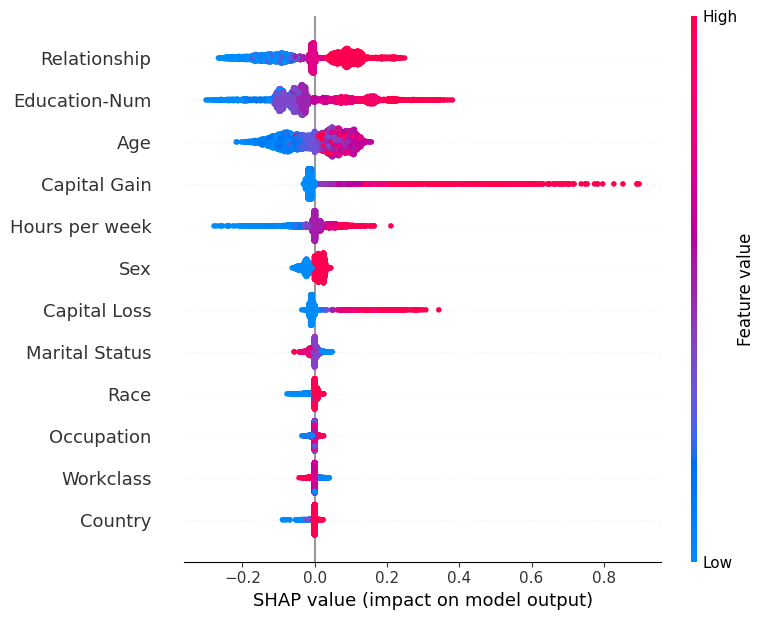

In [ ]:
# shap_values is an array with shape (n_samples, n_features)
shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns)

In [ ]:
import pickle

In [ ]:

with open('saved_shap/tabresnet_shap_values_adult.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [ ]:
with open('saved_shap/tabresnet_shap_values_adult.pkl', 'rb') as f:
    shap_values = pickle.load(f)

### Quantus

In [ ]:
# ---------------------------
# Wrap Model for Quantus FaithfulnessCorrelation
# ---------------------------
class TorchModelWrapper(nn.Module):
    def __init__(self, model):
        super(TorchModelWrapper, self).__init__()
        self.model = model
        self.model.eval()

    def forward(self, x):
        return self.model(x)

    def predict(self, X):
        X = np.atleast_2d(X)
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float()
            logits = self.model(X_tensor)
            probs = torch.softmax(logits, dim=1).cpu().numpy()  # shape: (n_samples, 2)
        return probs

    def shape_input(self, x, shape, channel_first):
        return np.atleast_2d(x)

wrapped_model = TorchModelWrapper(model)
wrapped_model.eval()

TorchModelWrapper(
  (model): TabResNet(
    (input_projection): Linear(in_features=12, out_features=16, bias=True)
    (resblocks): ModuleList(
      (0-1): 2 x TabResBlock(
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ln1): Linear(in_features=16, out_features=32, bias=True)
        (relu1): ReLU()
        (drop1): Dropout(p=0.2, inplace=False)
        (ln2): Linear(in_features=32, out_features=16, bias=True)
        (drop2): Dropout(p=0.05, inplace=False)
      )
    )
    (predblock): Sequential(
      (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [ ]:
# ---------------------------
# Evaluate FaithfulnessCorrelation with Quantus using SHAP attributions
# ---------------------------
# Ensure y_test is of integer type
y_test_int = y_test_np.astype(np.int64)

In [ ]:
# Apply Complexity metric using SHAP attributions
Complexity_shap = quantus.Complexity(
    normalise=False,
    abs=True,  # Take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    aggregate_func=np.mean,  # Compute mean complexity over all samples
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
Complexity_shap = (Complexity_shap - min(Complexity_shap)) / (
    max(Complexity_shap) - min(Complexity_shap)
)

# Find mean
Complexity_shap = np.mean(Complexity_shap)

print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.7118238707228673


In [ ]:
Sparseness_shap = quantus.Sparseness(
    normalise=False,
    abs=True, # take absolute values of attributions
    disable_warnings=True,
    display_progressbar=True,
    return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Already scaled to 0-1 -> keep aggregated (mean)

print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  [np.float64(0.6369843674783338)]


In [ ]:
FaithfulnessCorrelation_shap = quantus.FaithfulnessCorrelation(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    subset_size=5, # features to perturb
    nr_runs=10,
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
FaithfulnessCorrelation_shap = (FaithfulnessCorrelation_shap - np.min(FaithfulnessCorrelation_shap)) / (
    np.max(FaithfulnessCorrelation_shap) - np.min(FaithfulnessCorrelation_shap)
)

# Find mean
FaithfulnessCorrelation_shap = np.mean(FaithfulnessCorrelation_shap)

print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.6292019934582465


In [ ]:
FaithfulnessEstimate_shap = quantus.FaithfulnessEstimate(
    perturb_baseline="white",
    perturb_func=quantus.baseline_replacement_by_indices,
    features_in_step=1, # features to perturb
    similarity_func=quantus.similarity_func.correlation_pearson,
    abs=True, # take absolute values of attributions
    normalise=False, # do not normalise ohe data
    return_aggregate=False, # (not) output 1 val instead of list of vals for all samples
    aggregate_func=np.mean,
    disable_warnings=True,
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    a_batch=shap_values,   # use SHAP attributions computed above
    explain_func=None      # explanations are precomputed
)

# Scale to 0-1
FaithfulnessEstimate_shap = (FaithfulnessEstimate_shap - np.min(FaithfulnessEstimate_shap)) / (
    np.max(FaithfulnessEstimate_shap) - np.min(FaithfulnessEstimate_shap)
)

# Find mean
FaithfulnessEstimate_shap = np.mean(FaithfulnessEstimate_shap)

print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/quantus/helpers/warn.py:257: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.6503076319361475


In [ ]:
LocalLipschitzEstimate_shap = quantus.LocalLipschitzEstimate(
    normalise=False,
    abs=True, # take absolute values of attributions
    nr_samples = 20,
    disable_warnings=True,
    display_progressbar=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "DeepLiftShap", "reduce_axes": ()},
    # explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

# Scale to 0-1
LocalLipschitzEstimate_shap = (LocalLipschitzEstimate_shap - np.min(LocalLipschitzEstimate_shap)) / (
    np.max(LocalLipschitzEstimate_shap) - np.min(LocalLipschitzEstimate_shap)
)

# Find mean
LocalLipschitzEstimate_shap = np.mean(LocalLipschitzEstimate_shap)

print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.19426315514786843


In [ ]:
RandomLogit_shap = quantus.RandomLogit(
    num_classes=2,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
    return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

# Already scaled to 0-1 -> keep aggregated (mean)

print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

  0%|          | 0/102.0 [00:00<?, ?it/s]

Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  [np.float64(0.6554645565518843)]


In [ ]:
MPRT_shap = quantus.MPRT(
    # similarity_func=quantus.similarity_func.correlation_spearman,
    return_average_correlation=True,
    # return_aggregate=True, # find the mean of the complexity from all samples
    aggregate_func=np.mean,
    layer_order="independent",
    similarity_func=quantus.ssim,
    disable_warnings=True,
    normalise=False,
    abs=True, # take absolute values of attributions
    display_progressbar=True,
)(
    model=wrapped_model,
    x_batch=X_test_np,
    y_batch=y_test_int,
    # a_batch=shap_values,   # use SHAP attributions computed above
    # explain_func=None      # explanations are precomputed
    a_batch=None,
    explain_func=quantus.explain,
    explain_func_kwargs={"method": "GradientShap", "reduce_axes": ()},
)

# Scale to 0-1
MPRT_shap = (MPRT_shap - np.min(MPRT_shap)) / (
    np.max(MPRT_shap) - np.min(MPRT_shap)
)

# Find mean
MPRT_shap = np.mean(MPRT_shap)

print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

  0%|          | 0/58617 [00:00<?, ?it/s]

Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.6883214614618629


In [ ]:
# Convert from list to int
Complexity_shap = np.float64(Complexity_shap)
Sparseness_shap = np.float64(Sparseness_shap)
MPRT_shap = np.float64(MPRT_shap)
RandomLogit_shap = np.float64(RandomLogit_shap)
FaithfulnessEstimate_shap = np.float64(FaithfulnessEstimate_shap)
FaithfulnessCorrelation_shap = np.float64(FaithfulnessCorrelation_shap)
LocalLipschitzEstimate_shap = np.float64(LocalLipschitzEstimate_shap)

# Rounding one by one
Complexity_shap = round(float(Complexity_shap), 4)
Sparseness_shap = round(float(Sparseness_shap), 4)
MPRT_shap = round(float(MPRT_shap), 4)
RandomLogit_shap = round(float(RandomLogit_shap), 4)
FaithfulnessEstimate_shap = round(float(FaithfulnessEstimate_shap), 4)
FaithfulnessCorrelation_shap = round(float(FaithfulnessCorrelation_shap), 4)
LocalLipschitzEstimate_shap = round(float(LocalLipschitzEstimate_shap), 4)

<ipython-input-27-acd3cc85ebb0>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sparseness_shap = round(float(Sparseness_shap), 4)
<ipython-input-27-acd3cc85ebb0>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  RandomLogit_shap = round(float(RandomLogit_shap), 4)


In [ ]:
display(Markdown("#### Explanability scores"))

# Complexity: Complexity
print(
    f"Complexity: Complexity by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    Complexity_shap,
)

# Complexity: Sparseness
print(
    f"Complexity: Sparseness by Chalasani et al., 2020.\n"
    f"\n • SHAP = ",
    Sparseness_shap,
)

# Faithfulness: Faithfulness Estimate
print(
    f"Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    FaithfulnessEstimate_shap,
)

# Faithfulness: Faithfulness Correlation
print(
    f"Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.\n"
    f"\n • SHAP = ",
    FaithfulnessCorrelation_shap,
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.\n"
    f"\n • SHAP = ",
    LocalLipschitzEstimate_shap,
)

# Randomisation: MPRT
print(
    f"Randomisation: MPRT scores by Adebayo et al., 2018\n"
    f"\n • SHAP = ",
    MPRT_shap,
)

# Randomisation: RandomLogit
print(
    f"Randomisation: RandomLogit scores by Sixt et al., 2020.\n"
    f"\n • SHAP = ",
    RandomLogit_shap,
)

#### Explanability scores

Complexity: Complexity by Bhatt et al., 2020.

 • SHAP =  0.7118
Complexity: Sparseness by Chalasani et al., 2020.

 • SHAP =  0.637
Faithfulness: Faithfulness Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.6503
Faithfulness: Faithfulness Correlation by Bhatt et al., 2020.

 • SHAP =  0.6292
Robustness: Local Lipschitz Estimate by Alvarez-Melis et al., 2018.

 • SHAP =  0.1943
Randomisation: MPRT scores by Adebayo et al., 2018

 • SHAP =  0.6883
Randomisation: RandomLogit scores by Sixt et al., 2020.

 • SHAP =  0.6555


In [ ]:
display(Markdown("#### Explanability scores (grouped)"))

# Complexity: Complexity and Sparseness
print(
    f"Complexity"
    f"\n • SHAP = ",
    round(float((Complexity_shap+Sparseness_shap)/2), 4),
)

# Faithfulness: Faithfulness Estimate and Faithfulness Correlation
print(
    f"Faithfulness"
    f"\n • SHAP = ",
    round(float((FaithfulnessEstimate_shap+FaithfulnessCorrelation_shap)/2), 4),
)

# Robustness: Local Lipschitz Estimate
print(
    f"Robustness"
    f"\n • SHAP = ",
    round(float((LocalLipschitzEstimate_shap)), 4),
)

# Randomisation: MPRT and RandomLogit
print(
    f"Randomisation"
    f"\n • SHAP = ",
    round(float((MPRT_shap+RandomLogit_shap)/2), 4)
)

#### Explanability scores (grouped)

Complexity
 • SHAP =  0.6744
Faithfulness
 • SHAP =  0.6398
Robustness
 • SHAP =  0.1943
Randomisation
 • SHAP =  0.6719
